In [91]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from scipy.stats import pearsonr
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objs as go
from elasticsearch import Elasticsearch


## Data processing

The below data will be used for this model:

### Response variable: Regional population dataset

This dataset contains the population related information in Victoria, ranging from births, deaths to migration.
The key feature that we're interested in is the erp_YYYY column, which holds the estimated regional population for Melbourne


In [92]:

INDEX_NAME = "abs-regional_population_lga_2001-2021"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)
result = es_client.search(index=INDEX_NAME, body = {
'size' : 1000,
'query': {
    'match_all' : {}
}
})


es_data = []
for doc in result['hits']['hits']:
    es_data.append(doc['_source'])
response = pd.DataFrame(es_data)





### Predictor variable: Greater Melbourne rental affordability index

- This dataset contains information about the rental affordability 

In [93]:

INDEX_NAME = "rental_affordability"

es_client = Elasticsearch (
        'https://localhost:9200',
        verify_certs= False,
        ssl_show_warn= False,
        basic_auth=('elastic', 'elastic')
    )
es_client.indices.refresh(index=INDEX_NAME)
result = es_client.search(index=INDEX_NAME, body = {
'size' : 1000,
'query': {
    'match_all' : {}
}
})


es_data = []
for doc in result['hits']['hits']:
    es_data.append(doc['_source'])
rental_affordability = pd.DataFrame(es_data)
rental_affordability.columns = rental_affordability.columns.str.replace(' ', '')




## Data cleaning of rental affordability

 Now we proceed to look at rental_affordability

In [94]:
rental_affordability

,geography_name,rai_cityadjusted_total_2011_q2,rai_cityadjusted_total_2011_q3,rai_cityadjusted_total_2020_q1,rai_cityadjusted_total_2011_q1,state,rai_cityadjusted_total_2020_q3,rai_cityadjusted_total_2019_q4,rai_cityadjusted_total_2020_q2,rai_cityadjusted_total_2011_q4,...,rai_cityadjusted_total_2012_q1,rai_cityadjusted_total_2015_q3,rai_cityadjusted_total_2012_q4,rai_cityadjusted_total_2014_q3,rai_cityadjusted_total_2012_q3,rai_cityadjusted_total_2014_q4,rai_cityadjusted_total_2015_q1,rai_cityadjusted_total_2014_q1,rai_cityadjusted_total_2014_q2,rai_cityadjusted_total_2015_q4
0,3004,89.21491,88.30455,103.41070,84.13462,VIC,130.3781,105.39940,111.8524,99.46950,...,86.53846,96.15385,94.19152,98.19967,90.14423,97.16599,96.15385,102.56410,97.16599,102.16350
1,3008,77.26648,83.21006,95.31773,74.78632,VIC,135.7466,97.87088,105.3994,79.39308,...,82.41758,90.49774,92.30769,89.61912,88.30455,92.30769,90.49774,93.24009,94.19152,96.15385
2,3003,97.23423,100.62610,107.46610,88.75740,VIC,144.2308,109.61540,121.7949,81.64006,...,94.06355,103.71650,100.33440,107.33450,90.14423,102.56410,102.56410,113.96010,99.25558,119.60600
3,3005,NaN,NaN,NaN,NaN,VIC,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3006,81.64006,78.67133,99.65035,77.66272,VIC,144.2308,99.65035,121.7949,83.21006,...,81.64006,87.91209,88.75740,88.75740,81.64006,90.49774,87.08273,90.49774,90.49774,98.07692
5,3000,98.33916,98.33916,109.61540,93.91771,VIC,144.2308,109.61540,137.0192,100.62610,...,97.23423,102.56410,103.71650,107.33450,96.15385,107.33450,102.79250,102.56410,102.56410,114.04290


The dataset contains rental affordability index (RAI) values for different postal codes in Melbourne over multiple quarters in each year from 2011. To find the rental affordability for Melbourne as a whole, we will calculate the average RAI for each year .

In [95]:


# Strip leading and trailing spaces from column names
rental_affordability.columns = rental_affordability.columns.str.strip()

# Define the yearly columns
yearly_columns = {
    '2011': ['rai_cityadjusted_total_2011_q1', 'rai_cityadjusted_total_2011_q2', 'rai_cityadjusted_total_2011_q3', 'rai_cityadjusted_total_2011_q4'],
    '2012': ['rai_cityadjusted_total_2012_q1', 'rai_cityadjusted_total_2012_q2', 'rai_cityadjusted_total_2012_q3', 'rai_cityadjusted_total_2012_q4'],
    '2013': ['rai_cityadjusted_total_2013_q1', 'rai_cityadjusted_total_2013_q2', 'rai_cityadjusted_total_2013_q3', 'rai_cityadjusted_total_2013_q4'],
    '2014': ['rai_cityadjusted_total_2014_q1', 'rai_cityadjusted_total_2014_q2', 'rai_cityadjusted_total_2014_q3', 'rai_cityadjusted_total_2014_q4'],
    '2015': ['rai_cityadjusted_total_2015_q1', 'rai_cityadjusted_total_2015_q2', 'rai_cityadjusted_total_2015_q3', 'rai_cityadjusted_total_2015_q4'],
    '2016': ['rai_cityadjusted_total_2016_q1', 'rai_cityadjusted_total_2016_q2', 'rai_cityadjusted_total_2016_q3', 'rai_cityadjusted_total_2016_q4'],
    '2017': ['rai_cityadjusted_total_2017_q1', 'rai_cityadjusted_total_2017_q2', 'rai_cityadjusted_total_2017_q3', 'rai_cityadjusted_total_2017_q4'],
    '2018': ['rai_cityadjusted_total_2018_q1', 'rai_cityadjusted_total_2018_q2', 'rai_cityadjusted_total_2018_q3', 'rai_cityadjusted_total_2018_q4'],
    '2019': ['rai_cityadjusted_total_2019_q1', 'rai_cityadjusted_total_2019_q2', 'rai_cityadjusted_total_2019_q3', 'rai_cityadjusted_total_2019_q4'],
    '2020': ['rai_cityadjusted_total_2020_q1', 'rai_cityadjusted_total_2020_q2', 'rai_cityadjusted_total_2020_q3', 'rai_cityadjusted_total_2020_q4'],
    '2021': ['rai_cityadjusted_total_2021_q1', 'rai_cityadjusted_total_2021_q2', 'rai_cityadjusted_total_2021_q3', 'rai_cityadjusted_total_2021_q4']
}

# Calculate the average RAI for each year
yearly_avg_rai = {}

for year, cols in yearly_columns.items():
    available_cols = [col for col in cols if col in rental_affordability.columns]
    yearly_avg_rai[year] = rental_affordability[available_cols].mean(axis=1).mean()

# Convert to DataFrame 
rental_affordability_clean = pd.DataFrame.from_dict(yearly_avg_rai, orient='index', columns=['rental_affordability_index']).reset_index()
rental_affordability_clean.rename(columns={'index': 'year'}, inplace=True)

# change type for merging with other dataset

rental_affordability_clean['year'] = rental_affordability_clean['year'].astype(int)



In [96]:
rental_affordability_clean

,year,rental_affordability_index
0,2011,87.822181
1,2012,89.982100
2,2013,97.576380
3,2014,98.380814
4,2015,98.367963
5,2016,100.701249
6,2017,103.080538
7,2018,102.548016
8,2019,103.314577
9,2020,127.751459



### Cleaning up of response dataset
For retriving data of region = melbourne

In [97]:
# Remove spacing from column names

response.columns = response.columns.str.replace(' ', '')

In [98]:
# Get all key columns for our response dataset. The years range from 2011 to 2021, inclusive of start & end. 

KEY_RESPONSE_COLUMNS = ['lga_name_2021']

for i in range(2011, 2022):
    key_column = f"erp_{i}"
    KEY_RESPONSE_COLUMNS.append(key_column)
    

In [99]:
response[KEY_RESPONSE_COLUMNS]

,lga_name_2021,erp_2011,erp_2012,erp_2013,erp_2014,erp_2015,erp_2016,erp_2017,erp_2018,erp_2019,erp_2020,erp_2021
0,Boroondara,167062,168483,170485,172660,174753,177276,179677,181376,183197,182974,176632
1,Glen Eira,137152,139116,141260,143694,145924,148583,151457,153920,156535,158149,155123
2,Moonee Valley,112180,113673,115464,117763,120231,122871,125411,127906,130313,131702,129379
3,Moreland,154247,156967,160282,164099,167870,172294,176974,181780,185811,188660,184707
4,Port Phillip,97276,99893,102156,104451,106381,108627,110656,113265,115620,116417,112092
5,Yarra,78903,81268,83962,87228,89923,92894,95994,98567,101516,103076,99622
6,Bayside (Vic.),96119,96971,98252,99797,101268,102912,104282,105745,106856,107516,105580
7,Hobsons Bay,87395,88339,89188,90417,91674,93445,95071,96481,97765,98146,96317
8,Stonnington,98853,101410,103487,105894,108028,111003,113772,116281,117776,118567,114340
9,Unincorporated Vic,769,797,808,835,862,892,899,889,881,894,910


In [100]:
# Pick out row 7 to turn into dataframe ( melbourne)

response_clean = pd.DataFrame(response[KEY_RESPONSE_COLUMNS].iloc[7]).reset_index()

In [101]:
# Rename and clean columns

response_clean = response_clean.rename(columns={'index': 'year', 7: 'population'})
response_clean = response_clean.iloc[1:] # Remove unnceessary row
response_clean['year'] = response_clean['year'].str.removeprefix('erp_')
response_clean['year'] = response_clean['year'].astype(int)

In [102]:
response_clean

,year,population
1,2011,87395
2,2012,88339
3,2013,89188
4,2014,90417
5,2015,91674
6,2016,93445
7,2017,95071
8,2018,96481
9,2019,97765
10,2020,98146


merge the 2 dataset into a dataframe for analysis : analysis_df

In [103]:
analysis_df = pd.merge(rental_affordability_clean, response_clean, on='year')
analysis_df['year'] = pd.to_numeric(analysis_df['year'])
analysis_df['rental_affordability_index'] = pd.to_numeric(analysis_df['rental_affordability_index'])
analysis_df['population'] = pd.to_numeric(analysis_df['population'])

In [104]:
analysis_df

,year,rental_affordability_index,population
0,2011,87.822181,87395
1,2012,89.982100,88339
2,2013,97.576380,89188
3,2014,98.380814,90417
4,2015,98.367963,91674
5,2016,100.701249,93445
6,2017,103.080538,95071
7,2018,102.548016,96481
8,2019,103.314577,97765
9,2020,127.751459,98146


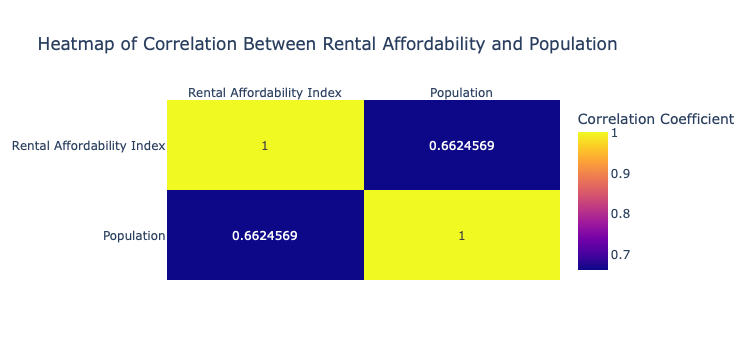

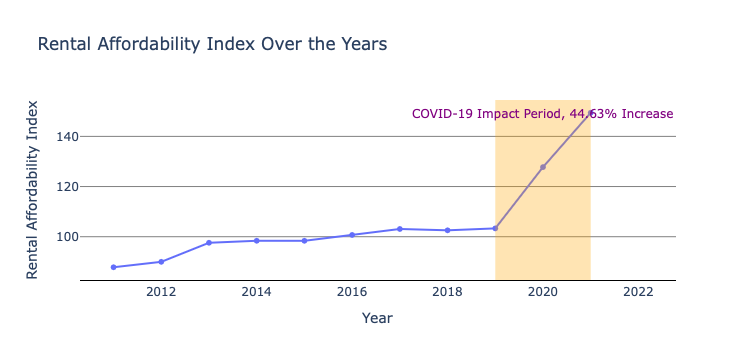

In [105]:


# Calculate Correlation Matrix
corr_matrix = analysis_df[['rental_affordability_index', 'population']].corr()

# Heatmap Visualization of Correlation
fig1 = px.imshow(corr_matrix, text_auto=True, aspect="auto", labels=dict(color="Correlation Coefficient"),
                 x=['Rental Affordability Index', 'Population'],
                 y=['Rental Affordability Index', 'Population'],
                 title='Heatmap of Correlation Between Rental Affordability and Population')
fig1.update_xaxes(side="top")

# Trend Visualization of Rental Affordability Index Over the Years
fig2 = px.line(analysis_df, x='year', y='rental_affordability_index', markers=True, title='Rental Affordability Index Over the Years', labels={'rental_affordability_index': 'Rental Affordability Index', 'year': 'Year'})
fig2.update_layout(plot_bgcolor='white', xaxis=dict(showline=True, showgrid=False, linecolor='black'), yaxis=dict(showgrid=True, gridcolor='grey'))

# Calculate Percentage Increase Due to COVID-19
index_2019 = analysis_df.loc[analysis_df['year'] == 2019, 'rental_affordability_index'].values[0]
index_2021 = analysis_df.loc[analysis_df['year'] == 2021, 'rental_affordability_index'].values[0]
percentage_increase = ((index_2021 - index_2019) / index_2019) * 100

# Adding COVID-19 Impact Period and Percentage Increase Annotation
fig2.add_vrect(x0="2019", x1="2021", fillcolor="orange", opacity=0.3, line_width=0)
fig2.add_annotation(x=2020, y=index_2021, text=f"COVID-19 Impact Period, {percentage_increase:.2f}% Increase", showarrow=False, font=dict(color="purple"))

# Display plots
fig1.show()
fig2.show()
